In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-woqa3ceg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-woqa3ceg
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=c2afa1466a61bd85e72417d319321f68e64c9e5f8c9c6547dcd52374abd91eba
  Stored in directory: /tmp/pip-ephem-wheel-cache-ic6er2_1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import torch
import clip
from PIL import Image

# Load the CLIP model and device
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 97.3MiB/s]


In [3]:
# Define class names (categories to recognize)
class_names = ["dog", "cat", "bird", "car", "bicycle", "human"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)


In [18]:
%cd "{od_path}"

# make directory for input data
DATA_PATH = "data"
%mkdir "{DATA_PATH}"

# download sample image, video data
!wget -P "{DATA_PATH}" https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.png
!wget -P "{DATA_PATH}" https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.mp4

# make directory for output data
OUTPUT_PATH = "output"
%mkdir "{OUTPUT_PATH}"

[Errno 2] No such file or directory: '{od_path}'
/content
--2024-12-07 06:39:52--  https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8784826 (8.4M) [application/octet-stream]
Saving to: ‘data/dog.png’

dog.png             100%[===================>]   8.38M  --.-KB/s    in 0.03s   

2024-12-07 06:39:52 (244 MB/s) - ‘data/dog.png’ saved [8784826/8784826]

--2024-12-07 06:39:52--  https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP r

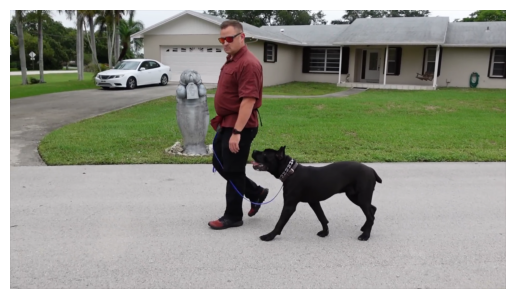

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
img_ex_path = "data/dog.png"
img_ex = Image.open(img_ex_path).convert('RGB')
plt.imshow(img_ex)
plt.axis('off')
plt.show()


In [22]:
from PIL import Image
import torch
import clip
import os

# Load CLIP model and preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define class names
class_names = ["dog", "cat", "bird", "car", "bicycle", "human"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)

# Path to the downloaded image
image_path = os.path.join(DATA_PATH, "dog.png")

# Load and preprocess the image
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

# Perform zero-shot classification
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarities = (image_features @ text_features.T).squeeze(0)
    predicted_class = class_names[similarities.argmax().item()]

print(f"Predicted class for image: {predicted_class}")

# Save the prediction
output_image_prediction = os.path.join(OUTPUT_PATH, "dog_image_prediction.txt")
with open(output_image_prediction, "w") as f:
    f.write(f"Predicted class for dog.png: {predicted_class}\n")
print(f"Image prediction saved to: {output_image_prediction}")


Predicted class for image: dog
Image prediction saved to: output/dog_image_prediction.txt


In [21]:
import cv2
from PIL import Image

# Path to the video
video_path = os.path.join(DATA_PATH, "dog.mp4")
cap = cv2.VideoCapture(video_path)

frame_count = 0
predictions = []

# Process video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process every 10th frame for efficiency
    if frame_count % 10 == 0:
        # Convert the frame (numpy array) to PIL Image
        frame_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Preprocess the frame for CLIP
        frame_tensor = preprocess(frame_image).unsqueeze(0).to(device)

        # Perform zero-shot classification
        with torch.no_grad():
            frame_features = model.encode_image(frame_tensor)
            frame_features /= frame_features.norm(dim=-1, keepdim=True)
            similarities = (frame_features @ text_features.T).squeeze(0)
            predicted_class = class_names[similarities.argmax().item()]
            predictions.append(predicted_class)

        print(f"Processed frame {frame_count}: Predicted - {predicted_class}")

    frame_count += 1

cap.release()

# Save predictions to a file
output_video_predictions = os.path.join(OUTPUT_PATH, "video_predictions.txt")
with open(output_video_predictions, "w") as f:
    for i, prediction in enumerate(predictions):
        f.write(f"Frame {i}: {prediction}\n")
print(f"Video predictions saved to: {output_video_predictions}")


Processed frame 0: Predicted - dog
Processed frame 10: Predicted - dog
Processed frame 20: Predicted - dog
Processed frame 30: Predicted - dog
Processed frame 40: Predicted - dog
Processed frame 50: Predicted - dog
Processed frame 60: Predicted - dog
Processed frame 70: Predicted - dog
Processed frame 80: Predicted - dog
Processed frame 90: Predicted - dog
Processed frame 100: Predicted - dog
Processed frame 110: Predicted - dog
Processed frame 120: Predicted - dog
Processed frame 130: Predicted - dog
Processed frame 140: Predicted - dog
Processed frame 150: Predicted - dog
Processed frame 160: Predicted - dog
Processed frame 170: Predicted - dog
Processed frame 180: Predicted - dog
Processed frame 190: Predicted - dog
Processed frame 200: Predicted - dog
Processed frame 210: Predicted - dog
Processed frame 220: Predicted - dog
Processed frame 230: Predicted - dog
Processed frame 240: Predicted - dog
Processed frame 250: Predicted - dog
Processed frame 260: Predicted - dog
Processed fr

In [23]:
from collections import Counter

# Count occurrences of each class
prediction_counts = Counter(predictions)
most_common_class = prediction_counts.most_common(1)[0]

print(f"Most common predicted class in video: {most_common_class[0]} ({most_common_class[1]} frames)")

# Save summary
summary_path = os.path.join(OUTPUT_PATH, "video_summary.txt")
with open(summary_path, "w") as f:
    f.write(f"Most common class: {most_common_class[0]} ({most_common_class[1]} frames)\n")
print(f"Video summary saved to: {summary_path}")


Most common predicted class in video: dog (44 frames)
Video summary saved to: output/video_summary.txt


In [24]:
# Annotate video frames with predictions
output_video_path = os.path.join(OUTPUT_PATH, "annotated_dog.mp4")
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS),
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

frame_index = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset video to start
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Annotate every 10th frame with predictions
    if frame_index < len(predictions) and frame_index % 10 == 0:
        cv2.putText(frame, f"Prediction: {predictions[frame_index//10]}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    out.write(frame)
    frame_index += 1

cap.release()
out.release()
print(f"Annotated video saved to: {output_video_path}")


Annotated video saved to: output/annotated_dog.mp4
